In [11]:
import numpy as np
import pandas as pd
import optuna
import seaborn as sns
import shap
from sklearn.metrics import mean_squared_error as MSE, r2_score
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error as MAE
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [12]:
df = pd.read_csv("train.csv")
df

,id,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,104.0,12.5,0.25,0.25,0.25,0.75,69.7,42.1,58.2,50.2,24.3,41.2,16.00,0.26,0.477941,0.423927,34.043022,6079.08526
1,1,764.0,25.0,0.00,0.00,0.00,0.00,86.0,52.0,71.9,62.0,30.0,50.8,3.77,0.06,0.334594,0.354415,27.735098,2946.92602
2,2,621.0,25.0,0.50,0.25,0.75,0.63,86.0,52.0,71.9,62.0,30.0,50.8,34.00,0.56,0.468192,0.417915,34.838815,5323.30034
3,3,499.0,25.0,0.50,0.25,0.38,0.75,69.7,42.1,58.2,50.2,24.3,41.2,24.00,0.39,0.500558,0.427431,35.134955,6157.05484
4,4,439.0,12.5,0.25,0.38,0.50,0.75,77.4,46.8,64.7,55.8,27.0,45.8,24.00,0.39,0.520181,0.464067,37.029180,6992.82314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,661.0,25.0,0.50,0.38,0.38,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.00,0.39,0.489723,0.435764,34.769578,5628.71053
14996,14996,131.0,12.5,0.25,0.25,0.25,0.50,94.6,57.2,79.0,68.2,33.0,55.9,16.00,0.26,0.506988,0.458076,36.362837,6331.86722
14997,14997,444.0,12.5,0.25,0.38,0.50,0.50,77.4,46.8,64.7,55.8,27.0,45.8,1.00,0.10,0.615612,0.514570,45.718182,8413.65966
14998,14998,461.0,12.5,0.25,0.25,0.38,0.75,69.7,42.1,58.2,50.2,24.3,41.2,16.00,0.26,0.551234,0.463896,38.130192,6620.09877


In [13]:
# 1. Yuqori va past haroratlar farqlari
# Yuqori haroratlarning diapazoni: maksimal va minimal qiymatlar orasidagi farq
df['UpperTempRange'] = df['MaxOfUpperTRange'] - df['MinOfUpperTRange']
# Past haroratlarning diapazoni: maksimal va minimal qiymatlar orasidagi farq
df['LowerTempRange'] = df['MaxOfLowerTRange'] - df['MinOfLowerTRange']

# 2. Haroratning o'rtacha farqi
# O'rtacha yuqori va past haroratlar orasidagi farq
df['AvgTempDifference'] = df['AverageOfUpperTRange'] - df['AverageOfLowerTRange']

# 3. Changlatuvchilar faoliyati bo'yicha indeks
# Turli changlatuvchilar (ari turlari) faolligi bo'yicha indeks
df['PollinatorActivity'] = df[['honeybee', 'bumbles', 'andrena', 'osmia']].sum(axis=1)

# 4. Changlatuvchi turlar nisbati
# Masalan, asalari va boshqa changlatuvchilar nisbatlari
df['HoneybeeToBumblesRatio'] = df['honeybee'] / (df['bumbles'] + 1)  # Nolga bo'linmaslik uchun +1 qo'shildi
df['HoneybeeToAndrenaRatio'] = df['honeybee'] / (df['andrena'] + 1)
df['HoneybeeToOsmiaRatio'] = df['honeybee'] / (df['osmia'] + 1)

# 5. Yomg'ir kunlari soni
# Yomg'ir kunlari umumiy sonini hisoblash
df['TotalRainyDays'] = df['RainingDays'] * df['AverageRainingDays']

# 6. Yomg'ir intensivligi
# O'rtacha yomg'ir kunlari (yomg'irning necha kun davomida yog'ganligi) intensivligini hisoblash
df['RainIntensity'] = df['AverageRainingDays'] / (df['RainingDays'] + 1)  # Nolga bo'linmaslik uchun +1 qo'shildi


# 8. Urug' zichligi
# Urug' zichligini (har bir meva massasidagi urug'lar soni) aniqlash
df['SeedDensity'] = df['seeds'] / (df['fruitmass'] + 1)  # Nolga bo'linmaslik uchun +1 qo'shildi

# Yangi ustunlar bilan tanishish
df.head()


,id,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,...,UpperTempRange,LowerTempRange,AvgTempDifference,PollinatorActivity,HoneybeeToBumblesRatio,HoneybeeToAndrenaRatio,HoneybeeToOsmiaRatio,TotalRainyDays,RainIntensity,SeedDensity
0,0,104.0,12.5,0.25,0.25,0.25,0.75,69.7,42.1,58.2,...,27.6,25.9,17.0,1.50,0.200000,0.200000,0.142857,4.1600,0.015294,23.907842
1,1,764.0,25.0,0.00,0.00,0.00,0.00,86.0,52.0,71.9,...,34.0,32.0,21.1,0.00,0.000000,0.000000,0.000000,0.2262,0.012579,20.477548
2,2,621.0,25.0,0.50,0.25,0.75,0.63,86.0,52.0,71.9,...,34.0,32.0,21.1,2.13,0.400000,0.285714,0.306748,19.0400,0.016000,24.570446
3,3,499.0,25.0,0.50,0.25,0.38,0.75,69.7,42.1,58.2,...,27.6,25.9,17.0,1.88,0.400000,0.362319,0.285714,9.3600,0.015600,24.614121
4,4,439.0,12.5,0.25,0.38,0.50,0.75,77.4,46.8,64.7,...,30.6,28.8,18.9,1.88,0.181159,0.166667,0.142857,9.3600,0.015600,25.292001


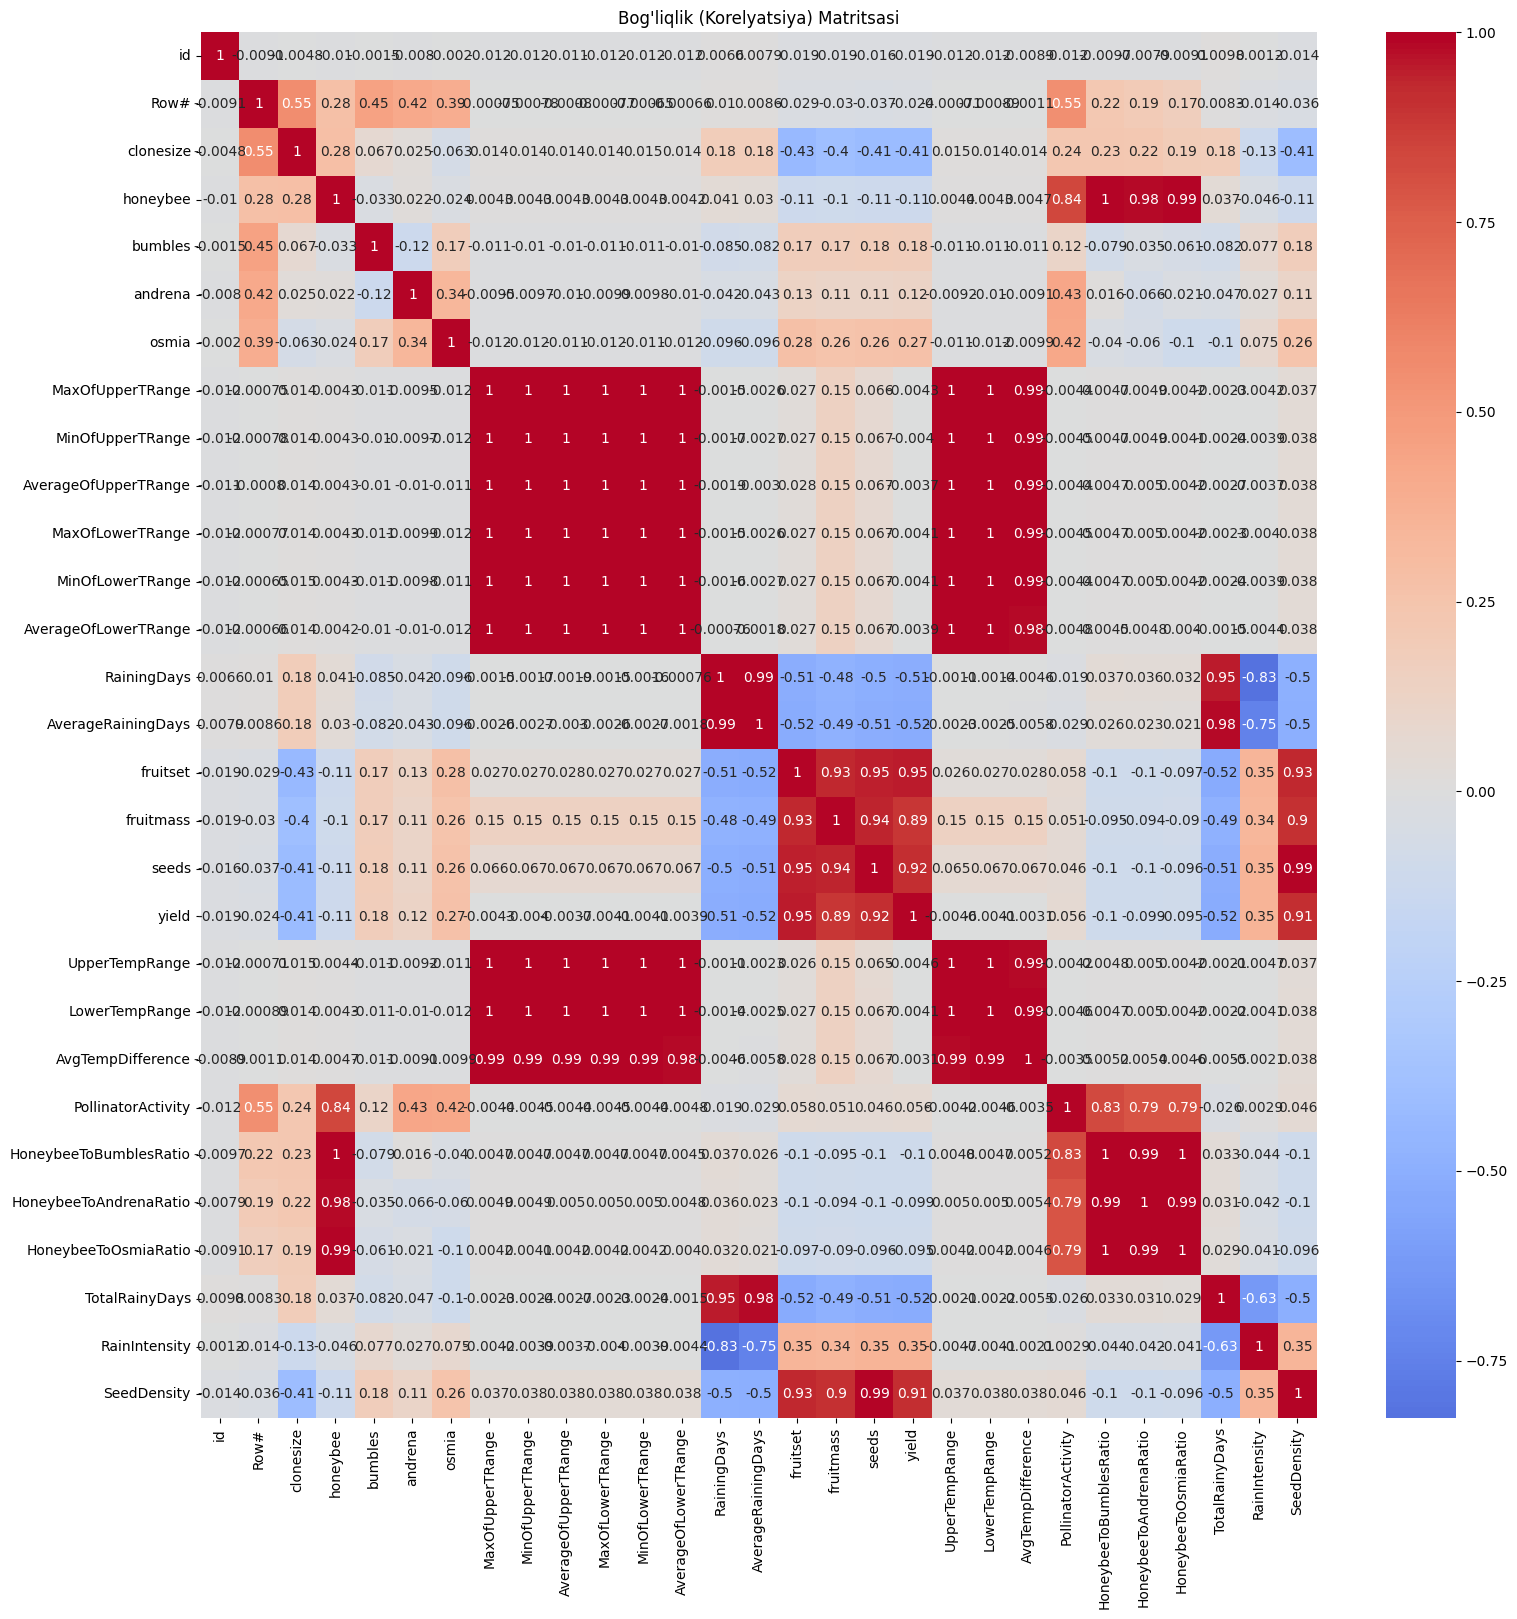

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bog'liqlik matritsasini hisoblash
correlation_matrix = df.corr()

# Issiqlik kartasi (Heatmap) yordamida korelyatsiya matritsasini tasvirlash
plt.figure(figsize=(18, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Bog'liqlik (Korelyatsiya) Matritsasi")
plt.show()


In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Ma'lumotlarni tayyorlash (target ustun 'yield', qolganlari features)
X = df.drop(columns=["yield"], axis=1)
y = df['yield']

# Train-test to'plamlarini ajratish
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest modelini yaratish
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # n_estimators daraxtlar soni

# Modelni o'rgatish
rf_model.fit(X_train, y_train)

# Test to'plamida bashorat qilish
y_pred = rf_model.predict(X_test)

# Modelni baholash
rf_mae = mean_absolute_error(y_test, y_pred)
print("Random Forest Regressor MAE:", rf_mae)


Random Forest Regressor MAE: 254.53721406086683


In [14]:
df_test = pd.read_csv("test.csv")

In [15]:
# 1. Yuqori va past haroratlar farqlari
# Yuqori haroratlarning diapazoni: maksimal va minimal qiymatlar orasidagi farq
df_test['UpperTempRange'] = df_test['MaxOfUpperTRange'] - df_test['MinOfUpperTRange']
# Past haroratlarning diapazoni: maksimal va minimal qiymatlar orasidagi farq
df_test['LowerTempRange'] = df_test['MaxOfLowerTRange'] - df_test['MinOfLowerTRange']

# 2. Haroratning o'rtacha farqi
# O'rtacha yuqori va past haroratlar orasidagi farq
df_test['AvgTempDifference'] = df_test['AverageOfUpperTRange'] - df_test['AverageOfLowerTRange']

# 3. Changlatuvchilar faoliyati bo'yicha indeks
# Turli changlatuvchilar (ari turlari) faolligi bo'yicha indeks
df_test['PollinatorActivity'] = df_test[['honeybee', 'bumbles', 'andrena', 'osmia']].sum(axis=1)

# 4. Changlatuvchi turlar nisbati
# Masalan, asalari va boshqa changlatuvchilar nisbatlari
df_test['HoneybeeToBumblesRatio'] = df_test['honeybee'] / (df_test['bumbles'] + 1)  # Nolga bo'linmaslik uchun +1 qo'shildi
df_test['HoneybeeToAndrenaRatio'] = df_test['honeybee'] / (df_test['andrena'] + 1)
df_test['HoneybeeToOsmiaRatio'] = df_test['honeybee'] / (df_test['osmia'] + 1)

# 5. Yomg'ir kunlari soni
# Yomg'ir kunlari umumiy sonini hisoblash
df_test['TotalRainyDays'] = df_test['RainingDays'] * df_test['AverageRainingDays']

# 6. Yomg'ir intensivligi
# O'rtacha yomg'ir kunlari (yomg'irning necha kun davomida yog'ganligi) intensivligini hisoblash
df_test['RainIntensity'] = df_test['AverageRainingDays'] / (df_test['RainingDays'] + 1)  # Nolga bo'linmaslik uchun +1 qo'shildi

# 8. Urug' zichligi
# Urug' zichligini (har bir meva massasidagi urug'lar soni) aniqlash
df_test['SeedDensity'] = df_test['seeds'] / (df_test['fruitmass'] + 1)  # Nolga bo'linmaslik uchun +1 qo'shildi

# Yangi ustunlar bilan tanishish
df_test.head()


,id,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,...,UpperTempRange,LowerTempRange,AvgTempDifference,PollinatorActivity,HoneybeeToBumblesRatio,HoneybeeToAndrenaRatio,HoneybeeToOsmiaRatio,TotalRainyDays,RainIntensity,SeedDensity
0,15000,402.0,12.5,0.25,0.38,0.38,0.75,69.7,42.1,58.2,...,27.6,25.9,17.0,1.76,0.181159,0.181159,0.142857,19.04,0.016,23.632554
1,15001,450.0,25.0,0.50,0.38,0.38,0.50,94.6,57.2,79.0,...,37.4,35.2,23.1,1.76,0.362319,0.362319,0.333333,0.10,0.050,25.620194
2,15002,594.0,25.0,0.50,0.25,0.63,0.75,77.4,46.8,64.7,...,30.6,28.8,18.9,2.13,0.400000,0.306748,0.285714,19.04,0.016,23.137974
3,15003,554.0,25.0,0.50,0.25,0.50,0.75,94.6,57.2,79.0,...,37.4,35.2,23.1,2.00,0.400000,0.333333,0.285714,0.10,0.050,24.983928
4,15004,307.0,12.5,0.25,0.25,0.75,0.75,69.7,42.1,58.2,...,27.6,25.9,17.0,2.00,0.200000,0.142857,0.142857,0.10,0.050,26.677364


In [21]:
y_pred_test = rf_model.predict(df_test)

In [23]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error

# Ma'lumotlarni tayyorlash (target ustun 'yield', qolganlari features)
X = df.drop(columns=["yield"])
y = df['yield']

# Train-test to'plamlarini ajratish
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optuna yordamida tuning qilish funksiyasi
def objective(trial):
    # Hyperparameterlarni tanlash
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_int("max_depth", 8, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # Random Forest modelini yaratish
    rf_model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42
    )

    # Cross-validation yordamida baholash
    cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    return -cv_scores.mean()  # MAE'ni minimallashtirish uchun ijobiy qiymat

# Optuna yordamida eng yaxshi parametrlarga ega modelni topish
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, n_jobs=-1)

# Eng yaxshi parametrlardan foydalanib model yaratish
best_params = study.best_params
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Test to'plamida bashorat qilish
y_pred = best_rf_model.predict(X_test)

# Modelni baholash
rf_mae = mean_absolute_error(y_test, y_pred)
print("Optuna bilan tuning qilingan Random Forest Regressor MAE:", rf_mae)

# Cross-validation yordamida baholash
cv_scores = cross_val_score(best_rf_model, X, y, cv=5, scoring='neg_mean_absolute_error')
print("Optuna bilan Cross-validated MAE:", -cv_scores.mean())  # Negative MAE'ni ijobiy qiymatga aylantiramiz


[I 2024-11-08 00:37:38,510] A new study created in memory with name: no-name-29718ba8-3a9b-40f3-81f0-16c638d3eef6


[I 2024-11-08 00:38:59,566] Trial 2 finished with value: 318.59030923219916 and parameters: {'n_estimators': 58, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 2 with value: 318.59030923219916.
[I 2024-11-08 00:39:39,106] Trial 5 finished with value: 253.84167479947888 and parameters: {'n_estimators': 109, 'max_depth': 26, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 5 with value: 253.84167479947888.
[I 2024-11-08 00:39:50,214] Trial 7 finished with value: 249.60583289635446 and parameters: {'n_estimators': 156, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 7 with value: 249.60583289635446.
[I 2024-11-08 00:40:00,933] Trial 6 finished with value: 322.1388334905232 and parameters: {'n_estimators': 96, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 7 with value: 249.60583289635446.
[I 2024-11-08 00

Optuna bilan tuning qilingan Random Forest Regressor MAE: 243.52518714674054
Optuna bilan Cross-validated MAE: 248.42962641464163


In [24]:
y_pred_test = best_rf_model.predict(df_test)

subm = pd.read_csv("sample_submission.csv")
subm['yield'] = y_pred_test
subm.to_csv("11_urinish.csv", index=False)

In [ ]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Ma'lumotlarni tayyorlash (target ustun 'yield', qolganlari features)
X = df.drop(columns=["yield"])
y = df['yield']

# Train-test to'plamlarini ajratish
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optuna yordamida tuning qilish funksiyasi
def objective(trial):
    # Hyperparameterlarni tanlash
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_int("max_depth", 8, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # Pipeline yaratish va modelni kiritish
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Standartlash
        ('regressor', RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            bootstrap=bootstrap,
            random_state=42
        ))
    ])

    # Cross-validation yordamida baholash
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    return -cv_scores.mean()  # MAE'ni minimallashtirish uchun ijobiy qiymat

# Optuna yordamida eng yaxshi parametrlarga ega modelni topish
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, n_jobs=-1)

# Eng yaxshi parametrlardan foydalanib pipeline yaratish
best_params = study.best_params
best_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standartlash
    ('regressor', RandomForestRegressor(**best_params, random_state=42))
])

# Modelni o'rgatish
best_pipeline.fit(X_train, y_train)

# Test to'plamida bashorat qilish
y_pred = best_pipeline.predict(X_test)

# Modelni baholash
rf_mae = mean_absolute_error(y_test, y_pred)
print("Optuna bilan tuning qilingan Random Forest Regressor MAE:", rf_mae)

# Cross-validation yordamida baholash
cv_scores = cross_val_score(best_pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')
print("Optuna bilan Cross-validated MAE:", -cv_scores.mean())  # Negative MAE'ni ijobiy qiymatga aylantiramiz


[I 2024-11-07 15:57:35,340] A new study created in memory with name: no-name-57015228-3002-458f-b32c-b956a105dbd3


In [ ]:
y_pred_test = best_pipeline.predict(df_test)

subm = pd.read_csv("sample_submission.csv")
subm['yield'] = y_pred_test
subm.to_csv("8_urinish.csv", index=False)

In [ ]:
import optuna
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

# Ma'lumotlarni tayyorlash (target ustun 'yield', qolganlari features)
X = df.drop(columns=["yield"])
y = df['yield']

# Train-test to'plamlarini ajratish
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optuna yordamida tuning qilish funksiyasi
def objective(trial):
    # Hyperparameterlarni tanlash (kengaytirilgan grid)
    n_estimators = trial.suggest_int("n_estimators", 200, 500)
    max_depth = trial.suggest_int("max_depth", 10, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    # Random Forest modelini kiritish
    rf_model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        max_features=max_features,
        random_state=42
    )

    # Pipeline yaratish va standartlashtirish
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', rf_model)
    ])

    # Cross-validation yordamida baholash (cv=10)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
    return -cv_scores.mean()  # MAE'ni minimallashtirish uchun ijobiy qiymat

# Optuna yordamida eng yaxshi parametrlarga ega modelni topish
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, n_jobs=-1)

# Eng yaxshi parametrlardan foydalanib Random Forest pipeline yaratish
best_params = study.best_params
best_rf_model = RandomForestRegressor(**best_params, random_state=42)

# Stacking Regressor uchun yordamchi modellarning ansamblini yaratish
stacked_model = StackingRegressor(
    estimators=[
        ('rf', best_rf_model),
        ('lr', LinearRegression()),
        ('knn', KNeighborsRegressor(n_neighbors=5)),
        ('dt', DecisionTreeRegressor(max_depth=10))
    ],
    final_estimator=LinearRegression()
)

# Voting Regressor (ansambl) yaratish
voting_model = VotingRegressor(
    estimators=[
        ('rf', best_rf_model),
        ('knn', KNeighborsRegressor(n_neighbors=5)),
        ('dt', DecisionTreeRegressor(max_depth=10))
    ]
)

# Barcha modellarning Pipeline yaratish
best_pipeline_2 = Pipeline([
    ('scaler', StandardScaler()),
    ('ensemble', stacked_model)  # `stacked_model` yoki `voting_model` tanlash mumkin
])

# Modelni o'rgatish
best_pipeline_2.fit(X_train, y_train)

# Test to'plamida bashorat qilish
y_pred = best_pipeline_2.predict(X_test)

# Modelni baholash
rf_mae = mean_absolute_error(y_test, y_pred)
print("Ansambl bilan tuning qilingan MAE:", rf_mae)

# Cross-validation yordamida baholash
cv_scores = cross_val_score(best_pipeline_2, X, y, cv=10, scoring='neg_mean_absolute_error')
print("Ansambl bilan Cross-validated MAE:", -cv_scores.mean())  # Negative MAE'ni ijobiy qiymatga aylantiramiz


[I 2024-11-07 17:58:55,215] A new study created in memory with name: no-name-2703ad80-2b97-4856-82f2-16efd25a4a40


[I 2024-11-07 18:01:54,481] Trial 7 finished with value: 262.68249266691186 and parameters: {'n_estimators': 266, 'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 7 with value: 262.68249266691186.
[I 2024-11-07 18:02:32,537] Trial 4 finished with value: 262.3131680235499 and parameters: {'n_estimators': 332, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 4 with value: 262.3131680235499.
[I 2024-11-07 18:02:33,541] Trial 2 finished with value: 261.6326200199338 and parameters: {'n_estimators': 326, 'max_depth': 32, 'min_samples_split': 10, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 2 with value: 261.6326200199338.
[I 2024-11-07 18:04:03,851] Trial 5 finished with value: 261.1004230100215 and parameters: {'n_estimators': 460, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': Fa

Ansambl bilan tuning qilingan MAE: 244.60379789086198
Ansambl bilan Cross-validated MAE: 246.96125437285224


In [ ]:
y_pred_test = best_pipeline_2.predict(df_test)

subm = pd.read_csv("sample_submission.csv")
subm['yield'] = y_pred_test
subm.to_csv("9_urinish.csv", index=False)

# blanding qilishim kk

In [13]:
import optuna
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, VotingRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
import numpy as np

# Ma'lumotlarni tayyorlash (target ustun 'yield', qolganlari features)
X = df.drop(columns=["yield"])
y = df['yield']

# Train-test to'plamlarini ajratish
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optuna yordamida tuning qilish funksiyasi
def objective(trial):
    # Random Forest parametrlari
    n_estimators = trial.suggest_int("n_estimators", 200, 500)
    max_depth = trial.suggest_int("max_depth", 10, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    # KNN uchun `n_neighbors` parametri
    knn_neighbors = trial.suggest_int("knn_neighbors", 3, 15)

    # Polynomial darajasi
    poly_degree = trial.suggest_int("poly_degree", 1, 3)

    # Feature selection uchun eng yaxshi N ta featurelarni tanlash uchun k
    k_best = trial.suggest_int("k_best", 5, X_train.shape[1])

    # Random Forest modelini yaratish
    rf_model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        max_features=max_features,
        random_state=42
    )

    # KNN modelini yaratish
    knn_model = KNeighborsRegressor(n_neighbors=knn_neighbors)

    # Pipeline yaratish va feature selection + scaling + polynomial
    pipeline = Pipeline([
        ('feature_selection', SelectKBest(score_func=f_regression, k=k_best)),
        ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False)),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),  # PCA bilan xususiyatlarni kamaytirish
        ('regressor', rf_model)  # Faqat Random Forest modelini tuning uchun qo'llayapmiz
    ])

    # Cross-validation yordamida baholash (cv=10)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
    return -cv_scores.mean()  # MAE'ni minimallashtirish uchun ijobiy qiymat

# Optuna yordamida eng yaxshi parametrlarga ega modelni topish
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, n_jobs=-1)

# Eng yaxshi parametrlardan foydalanib Random Forest va KNN yaratish
best_params = study.best_params
best_rf_model = RandomForestRegressor(**{k: v for k, v in best_params.items() if k not in ['k_best', 'knn_neighbors', 'poly_degree']}, random_state=42)
best_knn_model = KNeighborsRegressor(n_neighbors=best_params['knn_neighbors'])

# Feature selection va Polynomial darajasi parametrini olish
k_best = best_params['k_best']
poly_degree = best_params['poly_degree']

# Stacking Regressor uchun yordamchi modellarning ansamblini yaratish
stacked_model = StackingRegressor(
    estimators=[
        ('rf', best_rf_model),
        ('ridge', Ridge(alpha=1.0)),
        ('huber', HuberRegressor()),
        ('lasso', Lasso(alpha=0.1)),
        ('knn', best_knn_model),
        ('et', ExtraTreesRegressor(n_estimators=100, random_state=42)),
        ('kr', KernelRidge(alpha=1.0, kernel='rbf')),  # Kernel Ridge Regression qo'shildi
        ('dt', DecisionTreeRegressor(max_depth=10))
    ],
    final_estimator=LinearRegression()
)

# Voting Regressor (ansambl) yaratish
voting_model = VotingRegressor(
    estimators=[
        ('rf', best_rf_model),
        ('ridge', Ridge(alpha=1.0)),
        ('huber', HuberRegressor()),
        ('lasso', Lasso(alpha=0.1)),
        ('knn', best_knn_model),
        ('et', ExtraTreesRegressor(n_estimators=100, random_state=42)),
        ('kr', KernelRidge(alpha=1.0, kernel='rbf')),  # Kernel Ridge Regression qo'shildi
        ('dt', DecisionTreeRegressor(max_depth=10))
    ]
)

# Barcha modellarning Pipeline yaratish
best_pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_regression, k=k_best)),
    ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('ensemble', stacked_model)  # `stacked_model` yoki `voting_model` tanlash mumkin
])

# Modelni o'rgatish
best_pipeline.fit(X_train, y_train)

# Test to'plamida bashorat qilish
y_pred = best_pipeline.predict(X_test)

# Modelni baholash
rf_mae = mean_absolute_error(y_test, y_pred)
print("Ansambl bilan tuning qilingan MAE:", rf_mae)

# Cross-validation yordamida baholash
cv_scores = cross_val_score(best_pipeline, X, y, cv=10, scoring='neg_mean_absolute_error')
print("Ansambl bilan Cross-validated MAE:", -cv_scores.mean())  # Negative MAE'ni ijobiy qiymatga aylantiramiz


[I 2024-11-07 20:34:32,129] A new study created in memory with name: no-name-f60a3065-e576-4520-9f93-563a34821e1e


[I 2024-11-07 20:55:50,455] Trial 7 finished with value: 311.47936912969953 and parameters: {'n_estimators': 446, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'log2', 'knn_neighbors': 12, 'poly_degree': 1, 'k_best': 5}. Best is trial 7 with value: 311.47936912969953.
[I 2024-11-07 20:57:56,736] Trial 5 finished with value: 329.3188261622494 and parameters: {'n_estimators': 219, 'max_depth': 34, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2', 'knn_neighbors': 8, 'poly_degree': 3, 'k_best': 27}. Best is trial 7 with value: 311.47936912969953.
[I 2024-11-07 20:58:00,392] Trial 1 finished with value: 342.75792490592863 and parameters: {'n_estimators': 457, 'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'sqrt', 'knn_neighbors': 15, 'poly_degree': 2, 'k_best': 6}. Best is trial 7 with value: 311.47936912969953.
[I 2024-11-07 20:58:43,958] Trial

Ansambl bilan tuning qilingan MAE: 277.93170843858684
Ansambl bilan Cross-validated MAE: 282.2618142606865


In [ ]:
import optuna
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, VotingRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression, RFECV
from sklearn.compose import TransformedTargetRegressor
import numpy as np

# Ma'lumotlarni tayyorlash (target ustun 'yield', qolganlari features)
X = df.drop(columns=["yield"])
y = df['yield']

# Train-test to'plamlarini ajratish
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optuna yordamida tuning qilish funksiyasi
def objective(trial):
    # Random Forest parametrlari
    n_estimators = trial.suggest_int("n_estimators", 200, 500)
    max_depth = trial.suggest_int("max_depth", 10, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    # KNN uchun `n_neighbors` parametri
    knn_neighbors = trial.suggest_int("knn_neighbors", 3, 15)

    # Polynomial darajasi
    poly_degree = trial.suggest_int("poly_degree", 1, 3)

    # Feature selection uchun eng yaxshi N ta featurelarni tanlash uchun k
    k_best = trial.suggest_int("k_best", 5, X_train.shape[1])

    # Random Forest modelini yaratish
    rf_model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        max_features=max_features,
        random_state=42
    )

    # KNN modelini yaratish
    knn_model = KNeighborsRegressor(n_neighbors=knn_neighbors)

    # Pipeline yaratish va feature selection + scaling + polynomial
    pipeline = Pipeline([
        ('feature_selection', SelectKBest(score_func=f_regression, k=k_best)),
        ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False, interaction_only=True)),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),  # PCA bilan xususiyatlarni kamaytirish
        ('regressor', rf_model)  # Faqat Random Forest modelini tuning uchun qo'llayapmiz
    ])

    # Cross-validation yordamida baholash (cv=10)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
    return -cv_scores.mean()  # MAE'ni minimallashtirish uchun ijobiy qiymat

# Optuna yordamida eng yaxshi parametrlarga ega modelni topish
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, n_jobs=-1)

# Eng yaxshi parametrlardan foydalanib Random Forest va KNN yaratish
best_params = study.best_params
best_rf_model = RandomForestRegressor(**{k: v for k, v in best_params.items() if k not in ['k_best', 'knn_neighbors', 'poly_degree']}, random_state=42)
best_knn_model = KNeighborsRegressor(n_neighbors=best_params['knn_neighbors'])

# Feature selection va Polynomial darajasi parametrini olish
k_best = best_params['k_best']
poly_degree = best_params['poly_degree']

# Stacking Regressor uchun yordamchi modellarning ansamblini yaratish
stacked_model = StackingRegressor(
    estimators=[
        ('rf', best_rf_model),
        ('ridge', Ridge(alpha=1.0)),
        ('huber', HuberRegressor()),
        ('lasso', Lasso(alpha=0.1)),
        ('knn', best_knn_model),
        ('et', ExtraTreesRegressor(n_estimators=100, random_state=42)),
        ('kr', KernelRidge(alpha=1.0, kernel='rbf')),
        ('dt', DecisionTreeRegressor(max_depth=10)),
        ('svr', SVR(kernel='rbf', C=1.0, epsilon=0.1))  # SVR qo'shildi
    ],
    final_estimator=LinearRegression()
)

# Voting Regressor (ansambl) yaratish
voting_model = VotingRegressor(
    estimators=[
        ('rf', best_rf_model),
        ('ridge', Ridge(alpha=1.0)),
        ('huber', HuberRegressor()),
        ('lasso', Lasso(alpha=0.1)),
        ('knn', best_knn_model),
        ('et', ExtraTreesRegressor(n_estimators=100, random_state=42)),
        ('kr', KernelRidge(alpha=1.0, kernel='rbf')),
        ('dt', DecisionTreeRegressor(max_depth=10)),
        ('svr', SVR(kernel='rbf', C=1.0, epsilon=0.1))  # SVR qo'shildi
    ]
)

# Barcha modellarning Pipeline yaratish
best_pipeline = Pipeline([
    ('feature_selection', RFECV(estimator=best_rf_model, step=1, scoring='neg_mean_absolute_error', cv=5)),
    ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False, interaction_only=True)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('ensemble', stacked_model)  # `stacked_model` yoki `voting_model` tanlash mumkin
])

# Target Transforming (Log transformation for skewed target)
transformed_pipeline = TransformedTargetRegressor(regressor=best_pipeline, func=np.log1p, inverse_func=np.expm1)

# Modelni o'rgatish
transformed_pipeline.fit(X_train, y_train)

# Test to'plamida bashorat qilish
y_pred = transformed_pipeline.predict(X_test)

# Modelni baholash
rf_mae = mean_absolute_error(y_test, y_pred)
print("Ansambl bilan tuning qilingan MAE:", rf_mae)

# Cross-validation yordamida baholash
cv_scores = cross_val_score(transformed_pipeline, X, y, cv=10, scoring='neg_mean_absolute_error')
print("Ansambl bilan Cross-validated MAE:", -cv_scores.mean())  # Negative MAE'ni ijobiy qiymatga aylantiramiz


In [7]:
import optuna
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.base import clone
import numpy as np

# Ma'lumotlarni tayyorlash (target ustun 'yield', qolganlari features)
X = df.drop(columns=["yield"])
y = df['yield']

# Train-test to'plamlarini ajratish
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optuna yordamida tuning qilish funksiyasi
def objective(trial):
    # Hyperparameterlarni tanlash
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    max_depth = trial.suggest_int("max_depth", 8, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # Random Forest modelini yaratish
    rf_model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42
    )

    # Feature selection uchun SelectFromModel yordamida eng muhim features tanlash
    selector = SelectFromModel(rf_model, threshold="median")
    X_selected = selector.fit_transform(X_train, y_train)

    # Modelni baholash
    cv_scores = cross_val_score(rf_model, X_selected, y_train, cv=5, scoring='neg_mean_absolute_error')
    return -cv_scores.mean()  # MAE'ni minimallashtirish uchun ijobiy qiymat

# Optuna yordamida eng yaxshi parametrlarga ega modelni topish
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, n_jobs=-1)

# Eng yaxshi parametrlardan foydalanib model yaratish
best_params = study.best_params
best_rf_model = RandomForestRegressor(**best_params, random_state=42)

# Feature selection, scaling va blending uchun pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selector', SelectFromModel(best_rf_model, threshold="median")),
])

# X_train ni Feature Scaling va Feature Selection yordamida tayyorlash
X_train_transformed = pipeline.fit_transform(X_train, y_train)
X_test_transformed = pipeline.transform(X_test)

# Blending uchun modellardan foydalangan holda
blending_train, blending_valid, blending_y_train, blending_y_valid = train_test_split(
    X_train_transformed, y_train, test_size=0.5, random_state=42
)

# Blending modellar
base_model_1 = clone(best_rf_model)
base_model_2 = LinearRegression()

# Blending modellarini o'qitish
base_model_1.fit(blending_train, blending_y_train)
base_model_2.fit(blending_train, blending_y_train)

# Blending modellarining validatsiya prediktsiyalari
blending_pred_1 = base_model_1.predict(blending_valid)
blending_pred_2 = base_model_2.predict(blending_valid)

# Blending prediktsiyalarni birlashtirish
blending_predictions = np.column_stack((blending_pred_1, blending_pred_2))

# Blending uchun final model
final_model = RandomForestRegressor(n_estimators=50, random_state=42)
final_model.fit(blending_predictions, blending_y_valid)

# Test to'plamida blending modellarining prediktsiyalari
test_pred_1 = base_model_1.predict(X_test_transformed)
test_pred_2 = base_model_2.predict(X_test_transformed)
test_predictions = np.column_stack((test_pred_1, test_pred_2))

# Yakuniy blending modelida bashorat qilish
final_y_pred = final_model.predict(test_predictions)

# Modelni baholash
blending_mae = mean_absolute_error(y_test, final_y_pred)
print("Blending bilan yaxshilangan model MAE:", blending_mae)

# Cross-validation yordamida baholash
cv_scores = cross_val_score(final_model, blending_predictions, blending_y_valid, cv=5, scoring='neg_mean_absolute_error')
print("Cross-validated MAE (Blending):", -cv_scores.mean())


[I 2024-11-08 14:27:53,226] A new study created in memory with name: no-name-f6905fd8-e32b-47d3-8208-166fed16a95c
[I 2024-11-08 14:30:58,137] Trial 4 finished with value: 249.00244546206022 and parameters: {'n_estimators': 211, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 4 with value: 249.00244546206022.
[I 2024-11-08 14:31:11,858] Trial 1 finished with value: 252.71963831926004 and parameters: {'n_estimators': 160, 'max_depth': 23, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 4 with value: 249.00244546206022.
[I 2024-11-08 14:32:56,072] Trial 5 finished with value: 320.46197027267317 and parameters: {'n_estimators': 186, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 4 with value: 249.00244546206022.
[I 2024-11-08 14:33:33,952] Trial 9 finished with value: 248.79247462872846 and parameters: {'n_estimators': 160, 'max_depth': 12, 'min_samples_spl

Blending bilan yaxshilangan model MAE: 280.15679468406665
Cross-validated MAE (Blending): 272.3092813375


In [ ]:
import optuna
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.base import clone
import numpy as np

# Ma'lumotlarni tayyorlash (target ustun 'yield', qolganlari features)
X = df.drop(columns=["yield"])
y = df['yield']

# Train-test to'plamlarini ajratish
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optuna yordamida tuning qilish funksiyasi
def objective(trial):
    # Hyperparameterlarni tanlash
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    max_depth = trial.suggest_int("max_depth", 8, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # Random Forest modelini yaratish
    rf_model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42
    )

    # Feature selection uchun SelectFromModel yordamida eng muhim features tanlash
    selector = SelectFromModel(rf_model, threshold="median")
    X_selected = selector.fit_transform(X_train, y_train)

    # Modelni baholash
    cv_scores = cross_val_score(rf_model, X_selected, y_train, cv=5, scoring='neg_mean_absolute_error')
    return -cv_scores.mean()

# Optuna yordamida eng yaxshi parametrlarga ega modelni topish
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, n_jobs=-1)

# Eng yaxshi parametrlardan foydalanib model yaratish
best_params = study.best_params
best_rf_model = RandomForestRegressor(**best_params, random_state=42)

# Pipeline yaratish: Scaling, Feature Selection va Model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selector', SelectFromModel(best_rf_model, threshold="median")),
])

# Feature Scaling va Selection bilan transform qilish
X_train_transformed = pipeline.fit_transform(X_train, y_train)
X_test_transformed = pipeline.transform(X_test)

# Blending uchun o'qitish va validatsiya bo'linmasi
blending_train, blending_valid, blending_y_train, blending_y_valid = train_test_split(
    X_train_transformed, y_train, test_size=0.5, random_state=42
)

# Blending modellarini o'qitish
base_model_1 = clone(best_rf_model)
base_model_2 = LinearRegression()
base_model_1.fit(blending_train, blending_y_train)
base_model_2.fit(blending_train, blending_y_train)

# Blending validatsiya prediktsiyalari va qayta standartlashtirish
blending_predictions = np.column_stack((base_model_1.predict(blending_valid), base_model_2.predict(blending_valid)))
scaler = StandardScaler()
blending_predictions_scaled = scaler.fit_transform(blending_predictions)

# Final model yaratish
final_model = RandomForestRegressor(n_estimators=50, random_state=42)
final_model.fit(blending_predictions_scaled, blending_y_valid)

# Test uchun blending prediktsiyalari va qayta standartlashtirish
test_predictions = np.column_stack((base_model_1.predict(X_test_transformed), base_model_2.predict(X_test_transformed)))
test_predictions_scaled = scaler.transform(test_predictions)
final_y_pred = final_model.predict(test_predictions_scaled)

# Modelni baholash
blending_mae = mean_absolute_error(y_test, final_y_pred)
print("Blending bilan qayta standartlashtirilgan model MAE:", blending_mae)

# Cross-validation yordamida baholash
cv_scores = cross_val_score(final_model, blending_predictions_scaled, blending_y_valid, cv=5, scoring='neg_mean_absolute_error')
print("Cross-validated MAE (Blending, qayta standartlashtirilgan):", -cv_scores.mean())


[I 2024-11-09 19:04:50,645] A new study created in memory with name: no-name-efe805be-8b14-4385-952a-c3d43b2ec272


In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Ma'lumotlarni tayyorlash (target ustun 'yield', qolganlari features)
X = df.drop(columns=["yield"])
y = df['yield']

# Train-test to'plamlarini ajratish
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Regressor modelini yaratish
rf_model = RandomForestRegressor(n_estimators=400, max_depth=20, random_state=42)

# Modelni o'qitish
rf_model.fit(X_train, y_train)

# Test to'plamida bashorat qilish
y_pred = rf_model.predict(X_test)

# Modelni baholash
rf_mae = mean_absolute_error(y_test, y_pred)
print("Random Forest Regressor MAE:", rf_mae)


Random Forest Regressor MAE: 252.15762856057574


In [18]:
y_pred_test = rf_model.predict(df_test)

subm = pd.read_csv("sample_submission.csv")
subm['yield'] = y_pred_test
subm.to_csv("12_urinish.csv", index=False)